<a href="https://colab.research.google.com/github/javierortuno1/pytorch-step-by-step/blob/main/Chapter05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 5 - Multiclass classification with CNN

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter5()
# This is needed to render the plots in this chapter
from plots.chapter5 import *

Finished!


In [3]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep

# Convolutions

Mathematical operation on two functions (f and g) that produces a third function (f*g) expressing how the shape of one is modified by the other.

In image processing, a convolution matrix is also called a kernel or filter. Typical image processing operations - like blurring, sharpening, edge detection, and more, are accomplished by performing a convolution between a kernel (filter) and an image.

And if we remember that weights used by a neuron can be interpreted as a weight image that will be multiplied by an input flattened image then we can say that those weights Images can be seen as the filter

## Filter / Kernel

Simply put, one defines a filter and applies this filter to an image. Usually, the filters are small square matrices

The convolution itself is performed by applying the filter on the image repeatedly.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/conv1.png?raw=1)

We can see that the gray region on the top left corner of the image, is the region to which the filter is being applied. That gray region is called the receptive field (where our vision or model vision is being currently focusing)

The shape follows the NCHW convention ->

* Input: one image, one channel, six-by-six pixels in size
* Filter: one filter, one channel, three-by-three pixels in size

And we have the asterisk (*) which represents the convolution operation between the two




In [74]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)
single.shape

(1, 1, 6, 6)

And the identity filter

In [75]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

## Convolving

Is the process where the filter modifies the selected region / receptive field by performing the convolution

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/conv2.png?raw=1)

1. Element-wise multiplication between the two, region and filter, and adds everything up.

In [76]:
# We silice or extract the 'region' from the "single" numpy.
# [start:end]
# single[take all, take all, take first 3 rows, take first 3 columns]
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity       # since both are matrix then we can perform the element-wise multiplication
total = filtered_region.sum()             # Adding everything up from the multiplication result matrix
total

9

And we're done for the first region of the image. Then we can say there are nin pixel values coming in, but only ONE value coming out

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/conv3.png?raw=1)

Here we can see that doing a convolution produces an image with a reduced size. And since the Identity filter only has a value of one in the center, as a result we get a simple number once is multiplied with the receptive region.

That result of the convolution value will be packed into a new shape or image called feature or activation map

## Moving Around

Next, we move the region one step to the right; Changing the receptive field and apply the filter again.

THE SIZE OF THE MOVEMENT, in pixels, is called a stride

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/stride1.png?raw=1)

In [77]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/conv5.png?raw=1)

In [78]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/conv6.png?raw=1)

We can keep moving the gray region (receptive region) until we can't move it anymore

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/conv7.png?raw=1)

In [79]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

In [80]:
last_horizontal_region * identity # Not posible because the region has undefined elements

ValueError: operands could not be broadcast together with shapes (1,1,3,2) (1,1,3,3) 

## Shape

Next, we go back to the left side and move down one step. If we repeate the operation, covering all valid regions, we'll end up with a resulting image that is smaller.

The size of the resulting image depend on the size of the filter

(hi, wi)*f = (hi-f+1, wi-f+1) = (6,6)*3x3 = 6-3+1, 6-3+1 = (4,4)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/conv8.png?raw=1)

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

If we want to keep the image size we will add padding

## Convolving in PyTorch

Let's try the convolution in python


In [ ]:
# Image (numpy 4D NCHW) and filter to tensors
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

Convolutions come in two flavors:

- Functional
- and Module

In [ ]:
# Functional takes the kernel/filter as argument
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

In [ ]:
# Module has learnable weights to represent the kernel/filter -> the Filter is learned by the module/layer
# - in_channels: number of channels of the input image (Deep, channel or number of Level of information)
# - out_channels: number of channels produced by the convolution (Deep, channel or number of level of information). It means that the module/layer is going to learn multiple filters and therefore different results
# - kernel_size: size of the (square) convolution filter/kernel
# - stride: the size of the movement of the selected region
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1) # This module/layer is a trainable component that learns the optimal filter weights
print(conv.weight)
conv(image) # It has a grad_fn meaning that its weights are going to be updated during the trainning process of the whole model or NN

The network will come up with filters that highlight features that are relevant to the task at hand

In [ ]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
conv_multiple.weight

In [ ]:
# We can also force a convolutional module to use a particular filter by setting its weights
with torch.no_grad():       # We need to strictily tell the conv layer to no-gradient operations
    conv.weight[0] = kernel_identity      # We provide the filter that cotians elements that are interpreted as weights
    conv.bias[0] = 0

setting the weights to get specific filters is at the heart of transfer learning. Someone else trained a model, and that model learned lots of useful filters, so we don't have to learn them again. We can set the corresponding weights and go from there

In [ ]:
conv(image)

## Striding

With stride of two, whe move two pixels to the right and down, the latest if is needed, before performing the filter

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/strider2.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/strider3.png?raw=1)

The larger the stride, the smaller the resulting image

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

In [ ]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

## Padding

It means stuffing. We need to stuff the original image so it can sustain the 'attack' on its size.

Simply add zeros around it, expanding the input image. This siple trick can be used to preserve the original size of the image

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/padding1.png?raw=1)

Two options:
- module/layer (Trasnformation componenet). In this case we do not train only transform the space
- functional (stateless functions)


In [ ]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

In [ ]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/paddings.png?raw=1)

In [ ]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

In [ ]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

In [ ]:
F.pad(image, pad=(1, 1, 1, 1), mode='circular')

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

## A REAL Filter

We can try an edge detector filter from traditional computer vision

In [ ]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/padding2.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/padding3.png?raw=1)

In [ ]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

# Pooling

It is about shrinking or reducing images by spliting the image into tiny chunk, performing operations on each chunk (that yields a single value), and puts the chunks together as the resulting image.

Let's check the max pooling filter/kernel

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/pooling1.png?raw=1)

In this case the stride is assumed to be the same size as the kernel.

The input image is split and we perform a simple max operation on each chunk and then putting this values together, in order, to produce smaller resulting image

The larger the pooling kernel, the smaller the resulting image

Again for pooling as filters we have both forms:

- Functional
- Module/layer

In [ ]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [ ]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

In [ ]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1) # here the stride does not match the kernel size but that does not matter, it will still perform the operation

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

# Flattening

It preserves the first dimension such that we keep the number of data points while collapsing all other dimensions.

It has two options

- Module/layer (As a trasnformation)
- using view or reshape (No functional version)

In [ ]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [ ]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

# Typical Architecture

A typical architecture uses a sequence of one or more typical convolutional blocks, with each block consisting of three operations:

1. Convolution
2. Activation function
3. Pooling

The number of channels/filters produced by each block, usually increases as more blocks are added.

After the sequence of blocks, the image gets flattened, form here it becomes a fairly standard problem that will go through a FFN

these Convolutional blocks are akind to the pre-processing of images and converting them into features. Let's call this part of the network a featurizer (the one that generates features)

## LeNet5

It is a seven-level convolutional neural network to recognize hand-written digits in 28x28 pixel images (The MNIST dataset)

It uses back-propagation to learn the convolution filters, instead of developing them manually

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/architecture_lenet.png?raw=1)

*Source: Generated using Alexander Lenail's [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author. For more details, see LeCun, Y., et al (1998).  [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Proceedings of the IEEE,86(11), 2278–2324*

The today version can be represented in code as:

In [4]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

LeNet-5 used three convolutional blocks, although the last one does not have a max pooling, because the convolution already produces a single pixel.

The number of channels increase as the image size decrease

- Input image: 1-channel 28x28 pixels
- first block: produces 6-channel 14x14 pixels
- second block: produces 16-channel 5x5 pixels
- third block: produces 120-channel 1x1 pixels

In the last block we have then 120 level of informations (channel) for one pixel therefore 120 elements/values/imageFeatures that are flattened and fed to a typical hidden layer with 84 units (F6). The last step is, obviously, the output layer, which produces ten logits (due to the ten units of the layer)to be used for digit classification (from 0 to 9, there are ten classes)

# A Multiclass Classification Problem

A problem is considered a multiclass classification problem if there are more than two classes. So, let's keep it as simple as possible and build a model to classify images into three classes.

## Data Generation

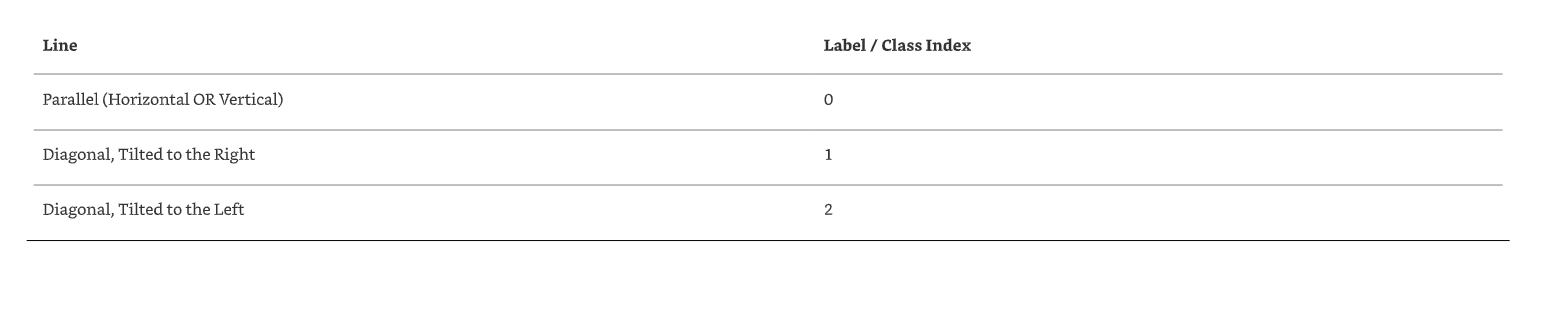

In [4]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

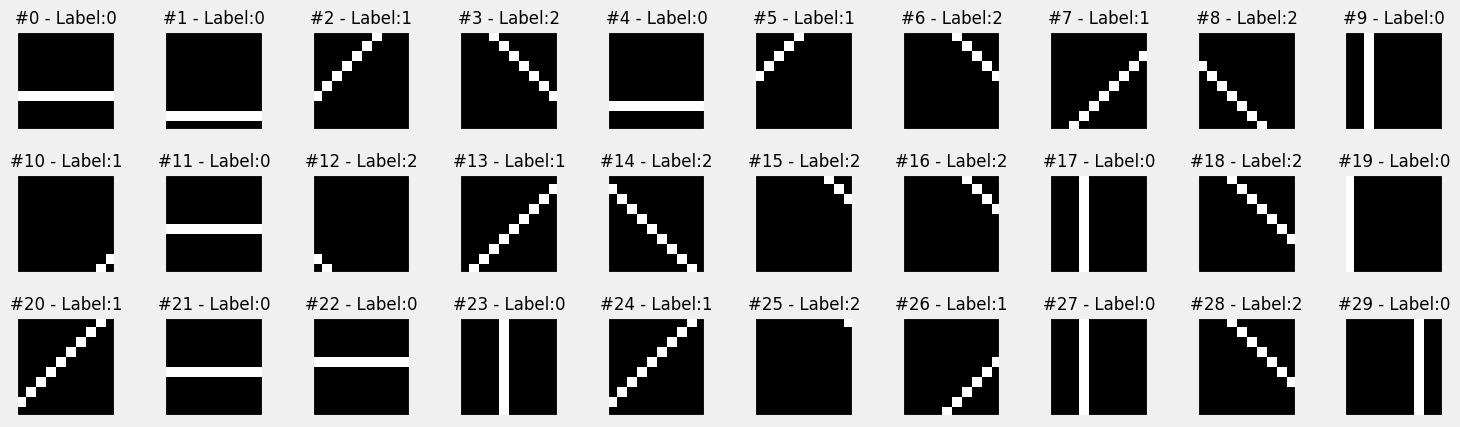

In [ ]:
fig = plot_images(images, labels, n_plot=30)

## Data Preparation

In this case we are not going to use data augmentation since it could produce images that are inconsistent with their labels.

and we are going to use only the min-max scaling by using the Normalize() tasnform in the Compose of transform pipeline

In [5]:
# Class for allowing the custom dataset to pass through the transform pipeline
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [6]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()                # It scale the intensity of the pixels to a range of [0,1]
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])        # It scale or normalize the pixel values centering to zero fo a range of [-1,-1].
                                                                    # Allowing the Network a full range of contrast, and letting it learn which differences are important to highlight

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Loss (It comes from the output layer analysis)

Sincew we're embracing multiclass calssification now, we need to use a different loss

Remember that a logit (z) is thet raw computation result of a neruon before the activation function; z = sum(weight * inputFeature) + bias

In a binary classificaiton problem, the model would produce one logit, and only one for each data point. Since we were answering a simple question "Does a given data point belong to the positive class?"

But a multiclass classification is more complex; We need to ask more questions; that is, we need to get log odds ratio (what are the chances) for every possible class regarding the data point. In other words, we need as many logits as there are classes.

Logit odd ratio is the probability of something happening divided by the probability of it not happening

odds ratio = p/(1-p)
For example:

- If probability p = 0.8
- Then odds ratio = 0.8/0.2 = 4
- This means the event is 4 times more likely to happen than not happen

Since sigmoid takes only one logit, then, we need something else to get probabilities, therefore the softmax!!

### Softmax

It retusn the contribution that a given class had to the sum iof odds ratios. The class with a higher odds ratio will have the largest contribution and this the highest probability.

Since the softmax is computed using the odds ratios instead of log odds ratios (logits), we need to exponentiate the logits!

$$
\Large
\begin{array}
& z & = \text{logit}(p) & = \text{log odds ratio }(p) & = \text{log}\left(\frac{p}{1-p}\right)
\\
e^z & = e^{\text{logit}(p)} & = \text{odds ratio }(p) & = \left(\frac{p}{1-p}\right)
\end{array}
$$

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{C-1}{e^{z_c}}}
$$

- C: number of classes
- i: index of a particular class

In our example we have three classes, so our model needs to output three logits (z0,z1,z2)

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

In [22]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

In [23]:
odds_ratios = torch.exp(logits)
odds_ratios # It is telling us scores that the first class has much better odds than the other two, and the second one has better odds than the third

tensor([4.0000, 1.0000, 0.5000])

In [24]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed     # Now we have the probabilites are proportional to the odds ratios. This data point most likely belongs to the first class since it has a probability of 72.73%

tensor([0.7273, 0.1818, 0.0909])

For computing the softmax or odds ratios for the classes we have two options:

- Functional (F.softmax())
- Module/layer (transformation)

In general, out models will produce logits with the shape (number of data points, number of classes), so the right dimension to apply softmax to is the last one (dim=-1) -> it indicates the last dimentsion

then logits [batch_size, num_classes]

In [30]:
nn.Softmax(dim=-1)(logits), F.softmax(logits, dim=-1)

(tensor([0.7273, 0.1818, 0.0909]), tensor([0.7273, 0.1818, 0.0909]))

However the Loss function expects log probabilites as inputs, therefore we will need a LogSoftmax. Function that returns the logarithm of the softmax and it has as well its F.log_softmax() and nn.LogSoftmax module/layer out of the box

### Negative Log Likelihood Loss (Loss for handlling multiple classes - it's an extension of the binary cross-entropy loss)



$$
\Large
\texttt{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
\\
\Large
\texttt{NLLLoss}(y)={-\frac{1}{(N_0+N_1+N_2)}\Bigg[{\sum_{i=1}^{N_0}{\text{log}(\text{P}(y_i=0))} + \sum_{i=1}^{N_1}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_2}{\text{log}(\text{P}(y_i=2))}}\Bigg]}
\\
\Large \texttt{NLLLoss}(y)={-\frac{1}{(N_0+\cdots+N_{C-1})}\sum_{c=0}^{C-1}{\sum_{i=1}^{N_c}{\text{log}(\text{P}(y_i=c))} }}
$$

The loss only considers the predicted probability for the true class

In [31]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

In [32]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1, 3), label) # It's the negative of the log probability corresponding to the class index (two) of the true label

tensor(2.3979)

We have as well two function for the loss:

- F.nll_loss()
- nn.NLLLoss()

In [33]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)
dummy_log_probs

tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

In [34]:
relevant_log_probs = torch.tensor([-1.5229, -1.7934, -1.0136, -2.0367, -1.9098])
-relevant_log_probs.mean()

tensor(1.6553)

In [35]:
loss_fn = nn.NLLLoss()          # Higher-order function
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.6553)

In [38]:
loss_fn = nn.NLLLoss(weight=torch.tensor([1., 1., 2.]))   # We can weight the classes
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.7188)

In [39]:
loss_fn = nn.NLLLoss(ignore_index=2)        # We can ignore a class
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.5599)

It takes log probabilities and lables

### Cross Entropy Loss (Another loss function for multiclass classification)

It take logits and labels

In [40]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

tensor(1.6553)

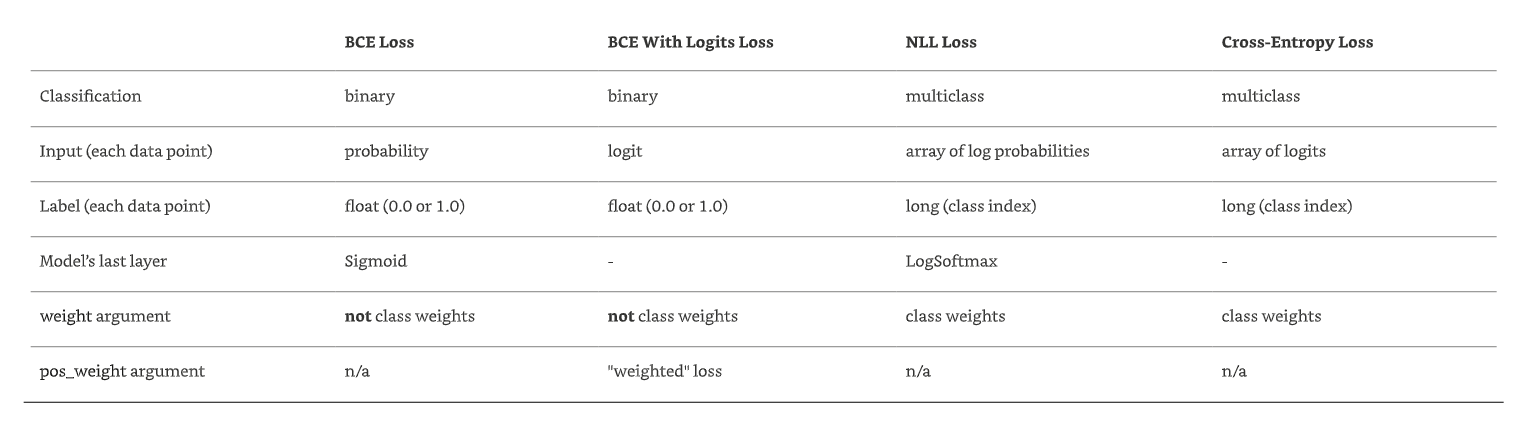

## Model Configuration (Our first convolutional neural network)

In [7]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer, which will encode our images into features using convolutions
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4            TYPICAL CONVOLUTIONAL BLOCK
n_channels = 1      # Filters or level of information
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))    # Convolutional layer (Filters are trained)
model_cnn1.add_module('relu1', nn.ReLU())                                                           # Activation function
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))                                         # Pooling layer for summarizing and reducing sizes and therefore reducing memmory cost and keeping the importnat information
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

- The image (1@10x10) is convolved with the kernel (3x3), and the resulting image has one channel, and is 8x8 pixels in size (1@8x8)
- A ReLU activation function is applied to the resulting image
- The "activated" image goes under a max pooling operation with a kernel size of 2x2, so it is divided into 16 chunks of size two-by-two, resulting in an image with one channel, but only 4x4 pixels in size (1@4x4)
- These 16 values of the resulting image, with only one channel or level of information, can be considered features, and are flattened into a tensor with 16 elements

In [8]:
# Classification, it uses the flattened featues to feed what would be a simple neural network
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3)) # In this case we expecting 3 classes and therefore 3 units/nodes. and here we have 3 logits one for each class

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/classification_softmax.png?raw=1)

In [9]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')       # Since our model producess logits, we must use the nn.CrossEntropyLoss() function
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

The backpropagation will flow backwards through:
- The classifier layers (fc2, relu2, fc1)
- The flattening layer
- All the convolutional layers (conv1,relu,maxp1)

The only layers that don't get updated are ones without learnable parametes (like Relu, MaxPool2d, and Flatten). But the convolutional layers do have weights and biases that get updated based on the gradients calculated during backpropagation

## Model Training

In [10]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)

In [11]:
sbs_cnn1.train(20)

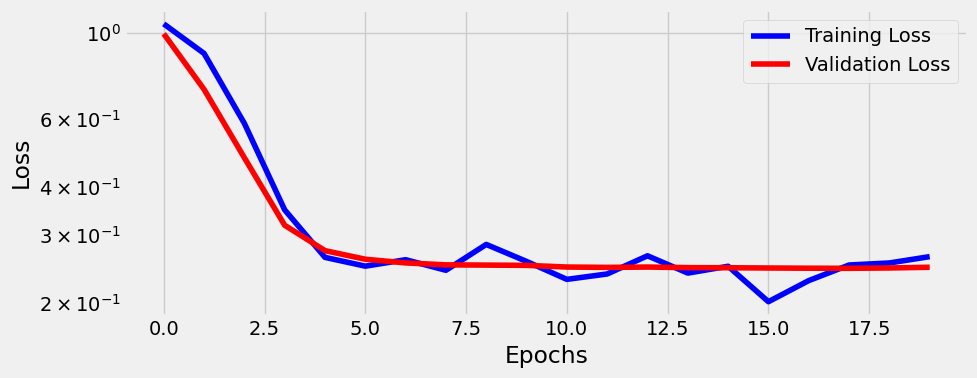

In [67]:
fig = sbs_cnn1.plot_losses()

## Visualizing Filters and More!

In [12]:
@staticmethod                   # It allows the method or function to be called on an uninstantiated class object.
                                #It is as if we're attaching a method to a class but that method does not depend on an instance of the class it is attached to
def _visualize_tensors(axs, x, y=None, yhat=None,
                       layer_name='', title=None):
    # The number of images is the number of subplots in a row
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # For each image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plots weight as an image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray',
            vmin=minv,
            vmax=maxv
        )
    return

setattr(StepByStep, '_visualize_tensors', _visualize_tensors)

### Static Method

In [ ]:
class Cat(object):
    def __init__(self, name):
        self.name = name

    @staticmethod
    def meow():
        print('Meow')

In [ ]:
Cat.meow()

Meow


### Visualizing Filters

Remember; Filters are like sheets or images that can be conv with an original image. The filter contains elements that in the case of convolutional layers, they are trainable params

In [13]:
weights_filter = model_cnn1.conv1.weight.data.cpu().numpy() # Obtaining the weights of the filtes and passing it to cpu an numpy for visualization
weights_filter.shape

(1, 1, 3, 3)

In [14]:
def visualize_filters(self, layer_name, **kwargs):
    try:
        # Gets the layer object from the model
        layer = self.model
        for name in layer_name.split('.'):
            layer = getattr(layer, name)
        # We are only looking at filters for 2D convolutions
        if isinstance(layer, nn.Conv2d):
            # Takes the weight information
            weights = layer.weight.data.cpu().numpy()
            # weights -> (channels_out (filter), channels_in, H, W)
            n_filters, n_channels, _, _ = weights.shape

            # Builds a figure
            size = (2 * n_channels + 2, 2 * n_filters)
            fig, axes = plt.subplots(n_filters, n_channels,
                                     figsize=size)
            axes = np.atleast_2d(axes)
            axes = axes.reshape(n_filters, n_channels)
            # For each channel_out (filter)
            for i in range(n_filters):
                StepByStep._visualize_tensors(
                    axes[i, :],
                    weights[i],
                    layer_name=f'Filter #{i}',
                    title='Channel'
                )

            for ax in axes.flat:
                ax.label_outer()

            fig.tight_layout()
            return fig
    except AttributeError:
        return

setattr(StepByStep, 'visualize_filters', visualize_filters)

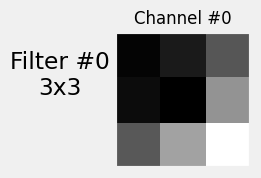

In [15]:
fig = sbs_cnn1.visualize_filters('conv1', cmap='gray')      # we can see all the filters or channels that will be trained

To really understand the effect this filter has on each image, we need to visualize the intermidate values produced by our model, namely, the output of each and every layer

### Hooks

A hook is simply a way to force a model to execute a function either after its forward pass or after its backward pass. Hence, there are forward hooks and backward hooks. We're using only **forward hooks** here, but the idea is the same for both

First, we create a function that is going to be hooked to the forward pass

In [19]:
dummy_model = nn.Linear(1, 1)

dummy_list = []                     # For storing the information that the hook fetches

def dummy_hook(layer, inputs, outputs):               # Forward hook function takes three arguments: a model, a model input tensor, and a model output tensor
    dummy_list.append((layer, inputs, outputs))

So, any function that takes three arguments, regardless of their names, can work as a hook. In our case we would like to keep the information that goes through the hook function

Let's hook the hook function to the model

In [20]:
dummy_handle = dummy_model.register_forward_hook(dummy_hook)    # Hooking the hook function to the model
dummy_handle          # The handle will allow us to keep track of the hooks attached to our model

Let's see it in action

In [21]:
dummy_x = torch.tensor([0.3])
dummy_model.forward(dummy_x)

tensor([-0.0552], grad_fn=<ViewBackward0>)

In [22]:
dummy_list

[]

We should call the whole model instead of the forward(x), to perform a forward pass. Otherwise, our hooks won't work

In [25]:
dummy_model(dummy_x)

tensor([-0.0552], grad_fn=<ViewBackward0>)

In [26]:
dummy_list

[(Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([-0.0552], grad_fn=<ViewBackward0>)),
 (Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([-0.0552], grad_fn=<ViewBackward0>))]

In [27]:
dummy_handle.remove()       # A hook is going to be hooked to the model until is explicitly removed

In [30]:
modules = list(sbs_cnn1.model.named_modules())          # Fetching a list of all named modules from a model
modules        # we get: ['', moduleWholeModel, moduleLayers]

[('',
  Sequential(
    (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=16, out_features=10, bias=True)
    (relu2): ReLU()
    (fc2): Linear(in_features=10, out_features=3, bias=True)
  )),
 ('conv1', Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))),
 ('relu1', ReLU()),
 ('maxp1',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc1', Linear(in_features=16, out_features=10, bias=True)),
 ('relu2', ReLU()),
 ('fc2', Linear(in_features=10, out_features=3, bias=True))]

In [39]:
layer_names = {layer: name for name, layer in modules[1:]}        # Print based on the layer values comming from the module

# Same thing written in multiple lines (more explicit)
# layer_names = {}
# for name, layer in modules[1:]:
#    layer_names[layer] = name

layer_names    # A dictionary (object); The hook function will take the layer instance as an argument and look its name up in the dictionary!

# Keys are the layer objects
# Values are their corresponding names

{Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)): 'conv1',
 ReLU(): 'relu1',
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): 'maxp1',
 Flatten(start_dim=1, end_dim=-1): 'flatten',
 Linear(in_features=16, out_features=10, bias=True): 'fc1',
 ReLU(): 'relu2',
 Linear(in_features=10, out_features=3, bias=True): 'fc2'}

Let's create a real hook function

In [40]:
visualization = {}

def hook_fn(layer, inputs, outputs):
    name = layer_names[layer]                   # it looks up the name of the layer and uses it as a key to a dictionary defined outside the hook function. Looking for the attribute of an object
    visualization[name] = outputs.detach().cpu().numpy()

In [48]:
layers_to_hook = ['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']

handles = {}

for name, layer in modules:
    if name in layers_to_hook:
        handles[name] = layer.register_forward_hook(hook_fn)

In [50]:
images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)

In [51]:
visualization.keys()

dict_keys(['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

In [52]:
for handle in handles.values():
    handle.remove()
handles = {}

In [16]:
setattr(StepByStep, 'visualization', {})
setattr(StepByStep, 'handles', {})

def attach_hooks(self, layers_to_hook, hook_fn=None):
    # Clear any previous values
    self.visualization = {}
    # Creates the dictionary to map layer objects to their names
    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules[1:]}

    if hook_fn is None:
        # Hook function to be attached to the forward pass
        def hook_fn(layer, inputs, outputs):
            # Gets the layer name
            name = layer_names[layer]
            # Detaches outputs
            values = outputs.detach().cpu().numpy()
            # Since the hook function may be called multiple times
            # for example, if we make predictions for multiple mini-batches
            # it concatenates the results
            if self.visualization[name] is None:
                self.visualization[name] = values
            else:
                self.visualization[name] = np.concatenate([self.visualization[name], values])

    for name, layer in modules:
        # If the layer is in our list
        if name in layers_to_hook:
            # Initializes the corresponding key in the dictionary
            self.visualization[name] = None
            # Register the forward hook and keep the handle in another dict
            self.handles[name] = layer.register_forward_hook(hook_fn)

def remove_hooks(self):
    # Loops through all hooks and removes them
    for handle in self.handles.values():
        handle.remove()
    # Clear the dict, as all hooks have been removed
    self.handles = {}

setattr(StepByStep, 'attach_hooks', attach_hooks)
setattr(StepByStep, 'remove_hooks', remove_hooks)

In [54]:
sbs_cnn1.attach_hooks(layers_to_hook=['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

In [20]:
images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)

In [56]:
sbs_cnn1.remove_hooks()

Don't forget the model is producing logits output. To get the predicted classes, we can simply take the index of the largest logit for each data point

In [59]:
predicted = np.argmax(logits, 1)
predicted

array([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0])

### Visualizing Feature Maps

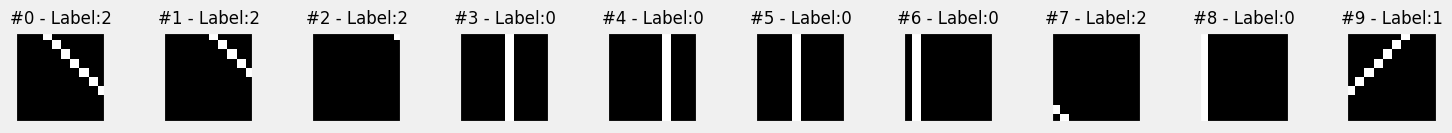

In [60]:
fig = plot_images(images_batch.squeeze(), labels_batch.squeeze(), n_plot=10)

In [17]:
# The outputs of the featurizer layers are the feature/activation maps
def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
    layers = filter(lambda l: l in self.visualization.keys(), layers)
    layers = list(layers)
    shapes = [self.visualization[layer].shape for layer in layers]
    n_rows = [shape[1] if len(shape) == 4 else 1
              for shape in shapes]
    total_rows = np.sum(n_rows)

    fig, axes = plt.subplots(total_rows, n_images,
                             figsize=(1.5*n_images, 1.5*total_rows))
    axes = np.atleast_2d(axes).reshape(total_rows, n_images)

    # Loops through the layers, one layer per row of subplots
    row = 0
    for i, layer in enumerate(layers):
        start_row = row
        # Takes the produced feature maps for that layer
        output = self.visualization[layer]

        is_vector = len(output.shape) == 2

        for j in range(n_rows[i]):
            StepByStep._visualize_tensors(
                axes[row, :],
                output if is_vector else output[:, j].squeeze(),
                y,
                yhat,
                layer_name=layers[i] \
                           if is_vector \
                           else f'{layers[i]}\nfil#{row-start_row}',
                title='Image' if (row == 0) else None
            )
            row += 1

    for ax in axes.flat:
        ax.label_outer()

    plt.tight_layout()
    return fig

setattr(StepByStep, 'visualize_outputs', visualize_outputs)

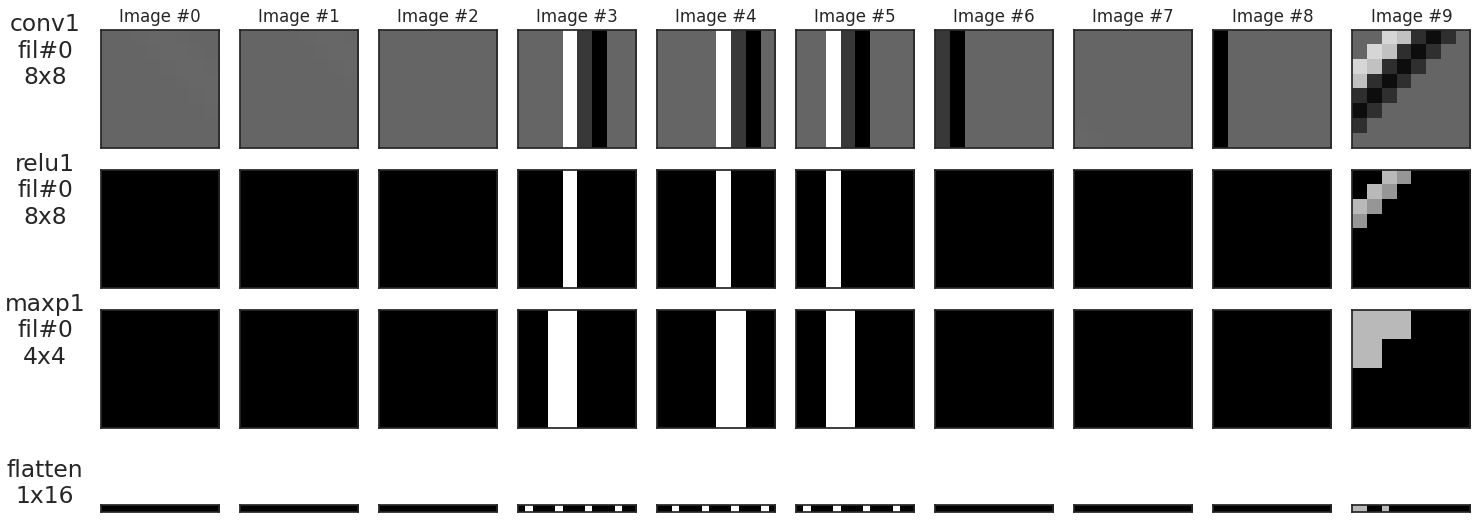

In [82]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']

with plt.style.context('seaborn-v0_8-white'):
    fig = sbs_cnn1.visualize_outputs(featurizer_layers)

### Visualizing Classifier Layers

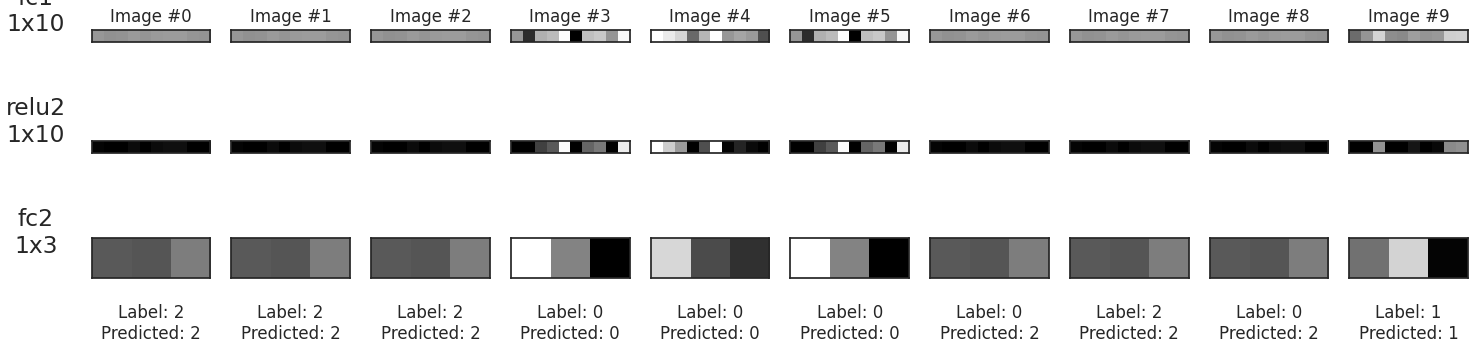

In [84]:
classifier_layers = ['fc1', 'relu2', 'fc2']

with plt.style.context('seaborn-v0_8-white'):
    fig = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

The classifier got eight out of ten right. It made wrong predictions for images #6 and #8. Unsurprisingly, these are the two images that got their vertical lines suppresed during the Featurizer. The filter doesn't seem to work so well whenever the vertical line is too close to the left edge of the image

### Accuracy

How good is the model actually?

The idea is to get the number of correct predictions and the number of data points in that class

In [33]:
def correct(self, x, y, threshold=.5):
    print("x.shape: ", x.shape)
    print("y.shape:", y.shape)
    self.model.eval()
    yhat = self.model(x.to(self.device))
    y = y.to(self.device)
    print("yhat.shape: ", yhat.shape)
    print("y.shape:", y.shape)
    self.model.train()

    # We get the size of the batch and the number of classes
    # (only 1, if it is binary)
    n_samples, n_dims = yhat.shape
    if n_dims > 1:
        # In a multiclass classification, the biggest logit
        # always wins, so we don't bother getting probabilities

        # This is PyTorch's version of argmax,
        # but it returns a tuple: (max value, index of max value)
        print(yhat)
        _, predicted = torch.max(yhat, 1)
        print("predicted", predicted)
        print("y_lables: ", y)
    else:
        n_dims += 1
        # In binary classification, we NEED to check if the
        # last layer is a sigmoid (and then it produces probs)
        if isinstance(self.model, nn.Sequential) and \
           isinstance(self.model[-1], nn.Sigmoid):
            predicted = (yhat > threshold).long()
        # or something else (logits), which we need to convert
        # using a sigmoid
        else:
            predicted = (F.sigmoid(yhat) > threshold).long()

    # How many samples got classified correctly for each class
    result = []
    for c in range(n_dims):
        n_class = (y == c).sum().item()                     # Number of items for the class 'c' in 'y'
        n_correct = (predicted[y == c] == c).sum().item()   # Number of items for class 'c' in 'predicted'
        result.append((n_correct, n_class))
    return torch.tensor(result)

setattr(StepByStep, 'correct', correct)

In [34]:
sbs_cnn1.correct(images_batch, labels_batch)

x.shape:  torch.Size([16, 1, 10, 10])
y.shape: torch.Size([16])
yhat.shape:  torch.Size([16, 3])
y.shape: torch.Size([16])
tensor([[ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [  8.7027,   1.7883,  -5.4678],
        [  6.4709,  -1.2642,  -2.8015],
        [  8.7027,   1.7883,  -5.4678],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [  0.8632,   6.2313,  -5.2358],
        [ 10.0063,   2.7433, -10.8433],
        [ -0.8574,   5.0248,  -2.7073],
        [ -0.4888,  -0.7405,   1.4701],
        [  1.2478,   7.5828,  -5.8709],
        [ -0.4888,  -0.7405,   1.4701],
        [  7.3204,  -0.0212,  -2.1209]], grad_fn=<AddmmBackward0>)
predicted tensor([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0])
y_lables:  tensor([2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0])


tensor([[5, 7],
        [3, 3],
        [6, 6]])

- three rows = three classes
- n_correct = correct predictions = first column
- n_class = number of datapoints for that class = second column

### Loader Apply

It allows to apply a function to each mini-batch, and stacks the results before applying a reducing function

In [36]:
@staticmethod
def loader_apply(loader, func, reduce='sum'):
    results = [func(x, y) for i, (x, y) in enumerate(loader)]
    results = torch.stack(results, axis=0)

    if reduce == 'sum':
        results = results.sum(axis=0)
    elif reduce == 'mean':
        results = results.float().mean(axis=0)

    return results

setattr(StepByStep, 'loader_apply', loader_apply)

In [37]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

x.shape:  torch.Size([16, 1, 10, 10])
y.shape: torch.Size([16])
yhat.shape:  torch.Size([16, 3])
y.shape: torch.Size([16])
tensor([[ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [  8.7027,   1.7883,  -5.4678],
        [  6.4709,  -1.2642,  -2.8015],
        [  8.7027,   1.7883,  -5.4678],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [  0.8632,   6.2313,  -5.2358],
        [ 10.0063,   2.7433, -10.8433],
        [ -0.8574,   5.0248,  -2.7073],
        [ -0.4888,  -0.7405,   1.4701],
        [  1.2478,   7.5828,  -5.8709],
        [ -0.4888,  -0.7405,   1.4701],
        [  7.3204,  -0.0212,  -2.1209]], grad_fn=<AddmmBackward0>)
predicted tensor([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0])
y_lables:  tensor([2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0])
x.shape:  torch.Size([16, 1, 10, 10])
y.shape: torch.Size([16])
yhat.shape:

tensor([[59, 67],
        [55, 62],
        [71, 71]])

## Putting It All Together

### Data Preparation

In [38]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Model Configuration

In [39]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

### Model Training

In [40]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)
sbs_cnn1.train(20)

### Visualizing Filters

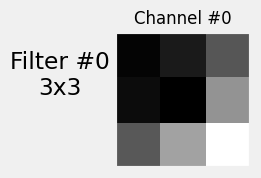

In [41]:
fig_filters = sbs_cnn1.visualize_filters('conv1', cmap='gray')

### Capturing Outputs

In [42]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

sbs_cnn1.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)
predicted = np.argmax(logits, 1)

sbs_cnn1.remove_hooks()

### Visualizing Feature Maps

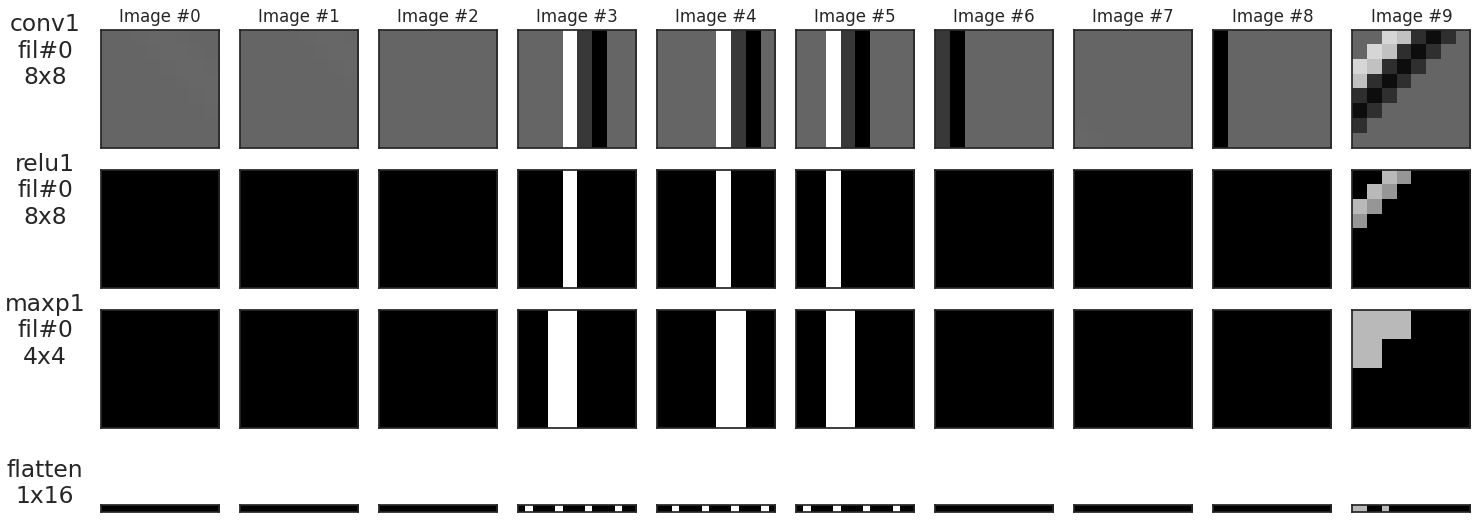

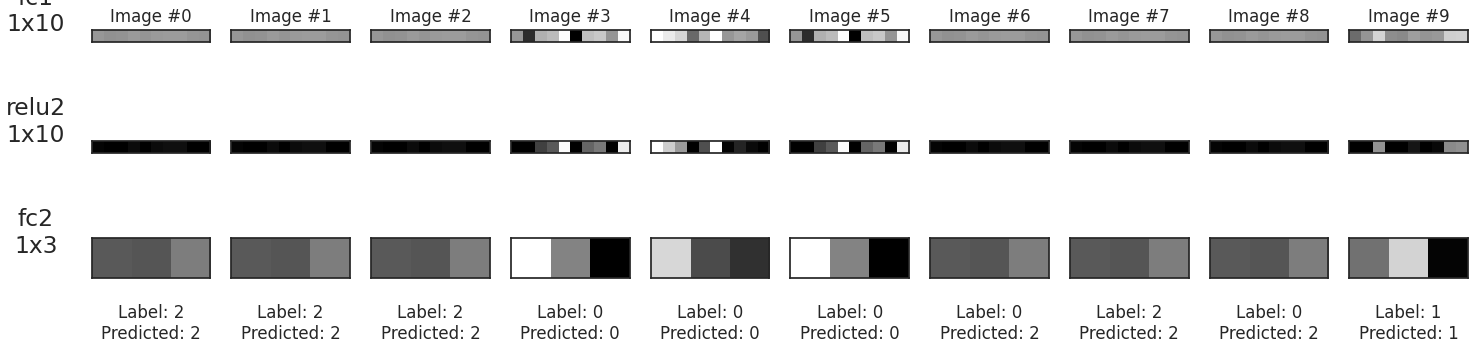

In [44]:
with plt.style.context('seaborn-v0_8-white'):
    fig_maps1 = sbs_cnn1.visualize_outputs(featurizer_layers)
    fig_maps2 = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

### Accuracy

In [45]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

x.shape:  torch.Size([16, 1, 10, 10])
y.shape: torch.Size([16])
yhat.shape:  torch.Size([16, 3])
y.shape: torch.Size([16])
tensor([[ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [  8.7027,   1.7883,  -5.4678],
        [  6.4709,  -1.2642,  -2.8015],
        [  8.7027,   1.7883,  -5.4678],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [ -0.4888,  -0.7405,   1.4701],
        [  0.8632,   6.2313,  -5.2358],
        [ 10.0063,   2.7433, -10.8433],
        [ -0.8574,   5.0248,  -2.7073],
        [ -0.4888,  -0.7405,   1.4701],
        [  1.2478,   7.5828,  -5.8709],
        [ -0.4888,  -0.7405,   1.4701],
        [  7.3204,  -0.0212,  -2.1209]], grad_fn=<AddmmBackward0>)
predicted tensor([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0])
y_lables:  tensor([2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0])
x.shape:  torch.Size([16, 1, 10, 10])
y.shape: torch.Size([16])
yhat.shape:

tensor([[59, 67],
        [55, 62],
        [71, 71]])